Step 1: Import libraries

In [1]:
import re
from difflib import SequenceMatcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

Step 2: Import data

Import movies.csv and drop the genres column

In [2]:
movies = pd.read_csv('data/movies.csv')
movies = movies.drop(['genres'], axis = 'columns')

Import ratings.csv and drop the timestamp column

In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings = ratings.drop(['timestamp'], axis = 'columns')

View the contents of the dataset

In [4]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


View how the movies are rated

In [6]:
ratings['rating'].sort_values().unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

Number of movies

In [7]:
movies.values.shape[0]

9742

Total number of ratings

In [8]:
ratings.values.shape[0]

100836

Number of unique users

In [9]:
ratings['userId'].nunique()

610

Step 3: Data Preprocessing and visualization

Set thresholds for popular movies and active users

In [10]:
popular_movies_thresh = 25
active_users_thresh = 100

Visualize the long-tail property for popular movies

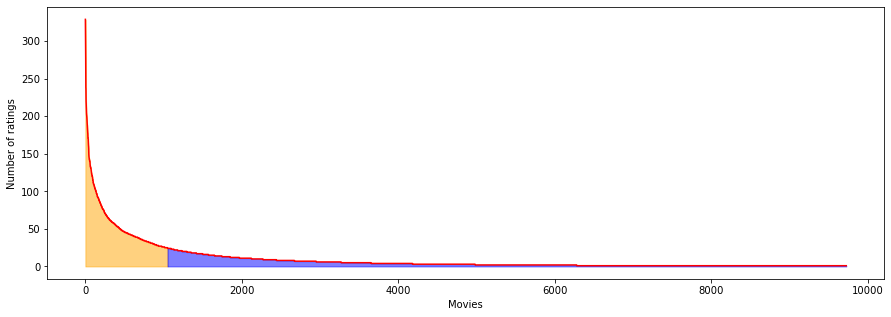

In [11]:
movies_count = pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending = False), columns = ['count'])
divider = len(movies_count.query('count >= @popular_movies_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize = (15, 5))

plt.plot(np.arange(len(movies_count)), movies_count['count'], color = 'red')
plt.xlabel('Movies')
plt.ylabel('Number of ratings')

ax.fill_between(np.arange(0, divider), 0, movies_count['count'][:divider], color = 'orange', alpha = 0.5)
ax.fill_between(np.arange(divider, len(movies_count)), 0, movies_count['count'][divider:], color = 'blue', alpha = 0.5)

Remove unpopular movies from the data

In [12]:
popular_movies_indices = movies_count.query('count >= @popular_movies_thresh').index
popular_ratings = ratings[ratings['movieId'].isin(popular_movies_indices)]

Number of rows in original ratings data

In [13]:
ratings.shape[0]

100836

Number of rows in ratings data after dropping unpopular movies

In [14]:
popular_ratings.shape[0]

62518

Number of movies before dropping unpopular movies

In [15]:
ratings.groupby('movieId').count().shape[0]

9724

Number of movies after dropping unpopular movies

In [16]:
popular_ratings.groupby('movieId').count().shape[0]

1050

Visualize the long-tail property for active users

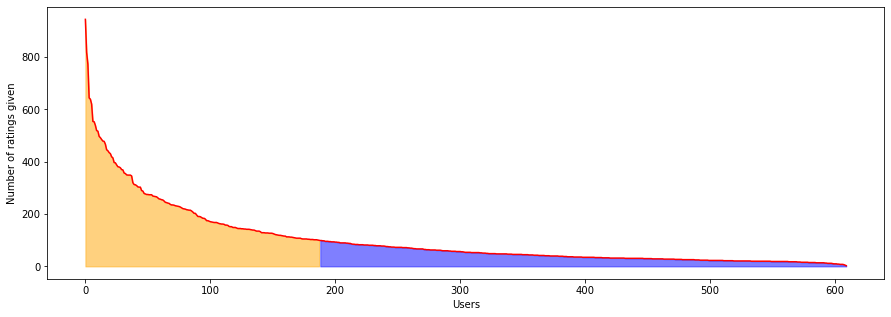

In [17]:
users_count = pd.DataFrame(popular_ratings.groupby('userId').size().sort_values(ascending = False), columns = ['count'])
divider = len(users_count.query('count >= @active_users_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize = (15, 5))

plt.plot(np.arange(len(users_count)), users_count['count'], color = 'r')
plt.xlabel('Users')
plt.ylabel('Number of ratings given')

ax.fill_between(np.arange(0, divider), 0, users_count['count'][:divider], color = 'orange', alpha = 0.5)
ax.fill_between(np.arange(divider, len(users_count)), 0, users_count['count'][divider:], color = 'blue', alpha = 0.5)

Remove non-active users from the data

In [18]:
active_users_indices = users_count.query('count >= @active_users_thresh').index
active_users_ratings = popular_ratings[popular_ratings['userId'].isin(active_users_indices)]

Number of rows in ratings data after removing unpopular movies

In [19]:
popular_ratings.shape[0]

62518

Number of rows in ratings data after removing unpopular movies and inactive users

In [20]:
active_users_ratings.shape[0]

44588

Number of users before removing inactive users

In [21]:
popular_ratings.groupby('userId').count().shape[0]

610

Number of users after removing unpopular movies and inactive users

In [22]:
active_users_ratings.groupby('userId').count().shape[0]

188

Step 4: Create pivot table and sparse matrix

In [23]:
pivot_table = active_users_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

Number of movies in the pivot table

In [24]:
pivot_table.index.shape[0]

1050

Number of user in the pivot table

In [25]:
pivot_table.columns.shape[0]

188

In [26]:
pivot_table.head()

userId,1,4,6,7,15,18,19,20,21,22,...,597,599,600,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,3.5,4.0,0.0,3.5,0.0,...,4.0,3.0,2.5,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,...,0.0,2.5,4.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,3.0,4.5,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0


Create a sparse matrix from the pivot table

In [27]:
sparse_matrix = csr_matrix(pivot_table.values)

Step 5: Map data

In [28]:
pivot_table_movies = movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id = {movie: i for i, movie in enumerate(pivot_table_movies)}

In [29]:
id_to_title = {v: k for k, v in title_to_id.items()}

Step 6: Train the model

In [30]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Get recommendations of movies

In [31]:
def find_matches(title_to_id, movie_title):
    movie_ids = np.array(list(title_to_id.values())).astype(int)
    titles = np.array(list(title_to_id.keys()))
    ratios = list()
    for title, movie_id in title_to_id.items():
        ratio = SequenceMatcher(None, movie_title, title, autojunk = False).ratio()
        ratios.append(ratio)
    titles, ids = titles[np.argsort(ratios)][-10:], movie_ids[np.argsort(ratios)][-10:]
    return list(reversed(list(zip(titles, ids))))

Given a title of a movie, display a Dropdown to display the options and to select the title

In [32]:
title = 'batman'
options = find_matches(title_to_id, title)

import ipywidgets as widgets
drop = widgets.Dropdown(options = options)
drop

Dropdown(options=(('Batman (1989)', 155), ('Batman Begins (2005)', 860), ('Watchmen (2009)', 941), ('Batman & …

Show recommendations for a given movie

In [33]:
movie_id = drop.value
test = pivot_table.iloc[movie_id, :].values.reshape(1, -1)

distances, indices = model_knn.kneighbors(test, n_neighbors = 10 + 1)
indices = indices.squeeze()[1:]

print('Recommendations for: ', id_to_title[movie_id])

for i, index in enumerate(indices):
    print(i+1, '.', id_to_title[index])


Recommendations for:  Batman (1989)
1 . Jurassic Park (1993)
2 . Terminator 2: Judgment Day (1991)
3 . Star Wars: Episode IV - A New Hope (1977)
4 . Star Wars: Episode VI - Return of the Jedi (1983)
5 . Indiana Jones and the Temple of Doom (1984)
6 . True Lies (1994)
7 . Terminator, The (1984)
8 . Independence Day (a.k.a. ID4) (1996)
9 . Batman Forever (1995)
10 . Indiana Jones and the Last Crusade (1989)


This completes movie recommendation system using machine learning.